We have one training DS so far, Letters DS. <br>
For the test, the plan is to use the following: <br>
1. MNNIST >
2. BMNIST
3. KMNIST
4. FMNIST
5. RANDOM > numbers-like and agnostic
<br>
<br>
EMNIST w/o numbers is the original data

# Import packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import bisect
from tqdm import tqdm

# Utility function

In [ ]:
def uncompressArray(file_dir):
  uncompressed_data = []
  with open(file_dir, 'rb') as f:
    loaded_file = np.load(f)
    ks = list(loaded_file.keys())
    print("First, check the data!")
    print(f"Keys: {ks}")
    ans = input("Please enter 'y' if you want to proceed: ")
    if ans == 'y':
      print("\nloading data !")
      for k in ks:
        uncompressed_data.append(loaded_file[k].copy())
        print(f"load: {k}")
    else:
      print("data is not loaded!")
  return uncompressed_data

def reshape_data(X):
  X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
  return X

In [ ]:
def Predict(class_preds=np.array([]), disc_preds=np.array([]), thrs=[]):
  class_preds = class_preds.tolist()
  disc_preds = disc_preds.tolist()
  if disc_preds and (not class_preds):
    print(f"Predicting using: Discriminator algorithm")
    Preds = predictDisc(disc_preds)
  elif class_preds and thrs and (not disc_preds):
    print(f"Predicting using: Threshold algorithm")
    Preds = predictThr(class_preds, thrs)
  elif class_preds and thrs and disc_preds:
    print(f"Predicting using: Combined algorithm")
    Preds = predictCombined(class_preds, disc_preds, thrs)
  else:
    print("Not enough OR wrong input data, cannot proceed with prediction!!")
    return None
  
  return Preds

def predictThr(class_preds, thrs):
  results = dict()
  for thr in thrs:
    results[thr] = list()
    for y_pred in class_preds:
      pred = np.argmax(y_pred)
      pred_confidence = y_pred[pred]

      result = 0
      if isOOD(pred_confidence, thr): result = 1
      results[thr].append(result)
  return results

def predictDisc(disc_preds):
  thr = 0.5
  results = dict()
  results[thr] = list()
  for disc_pred in disc_preds:
    result = 0
    if isOOD(disc_pred[0], thr): result = 1
    results[thr].append(result)
  return results

def predictCombined(class_preds, disc_preds, thrs):
  combined_results = dict()
  disc_results = predictDisc(disc_preds)
  thr_results = predictThr(class_preds, thrs)

  for thr in thr_results.keys():
    results = np.logical_or(disc_results[0.5]), np.array(thr_results[thr])
    combined_results[thr] = results.tolist()
  
  return combined_results

def isOOD(pred, thr):
  return True if pred < thr else False

def Evaluate(results, clean_data=False, Plot=True):
  eval_results = dict()
  for thr in results.keys():
    target = 0 if clean_data else 1
    acc = round(((results[thr].count(target))/len(results[thr]))*100, 2)
    eval_results[thr] = acc
  if Plot: plotLine(list(eval_results.keys()), list(eval_results.values()))
  return eval_results

def plotLine(x, y):
  plt.ylim(0, 110)
  plt.grid()
  plt.plot(x, y)
  plt.xlabel("threshold")
  plt.ylabel("Accuracy")

In [ ]:
def DPM(cdf, rcdf, test_decisions, n_classes, method=None):
  '''
  test_decisions: num test images x num of classes
  cdf: numb of classes x num of images in this class x 2 (weight, confidence/prob)
  '''

  Pis, Pk, preds = [], [], []
  for test_decision in tqdm(test_decisions):
    Pck = porbOOD(cdf, rcdf, test_decision, n_classes)
    Pk.append(Pck)

    Pi = porbID(cdf, rcdf, test_decision, n_classes, Pk)
    Pis.append(Pi)
    # print(type(Pis[-1]))
    # print(Pis[-1])
    # print(type(max(Pis[-1])))
    # print(max(Pis[-1]))
    # return

    pred = Pred(Pis, Pk, test_decision, n_classes)
    preds.append(pred)
  
  return preds, Pis, Pk

def porbOOD(cdf, rcdf, test_decision, n_classes):
  Pck = {'sum': 0, 'Fnj':[]}
  prod_k = 1
  for class_idx in range(n_classes):
    arr = abs(test_decision[class_idx]-np.array(rcdf[class_idx][:,0]))
    item_idx = int(np.where(arr == min(arr))[0][0])
    # item_idx = bisect.bisect_right(rcdf[class_idx][:,0], test_decision[class_idx]) # (list, value to compare)
    # item_idx = min(len(rcdf[class_idx][:,0])-1, item_idx) # the idx of item from the left side, max is the last element
    Pck['Fnj'].append(item_idx)
    Fnj = rcdf[class_idx][:,1][item_idx]
    prod_k *= Fnj
  Pck['sum'] = prod_k
  return Pck

def porbID(cdf, rcdf, test_decision, n_classes, Pk):
  Pi = []
  for class_idx in range(n_classes):
    prod_i = 1
    arr = abs(test_decision[class_idx]-np.array(cdf[class_idx][:,0]))
    item_idx = int(np.where(arr == min(arr))[0][0])
    # item_idx = bisect.bisect_right(cdf[class_idx][:,0], test_decision[class_idx]) # (list, value to compare)
    # item_idx = max(0, item_idx-1) # the idx of item from the left side, min is the first element
    Fpi = cdf[class_idx][:,1][item_idx]
    Fni = Pk[-1]['Fnj'][class_idx]
    Fnj = (Pk[-1]['sum'])/Fni
    prod_i *= Fpi*Fnj
    Pi.append(prod_i)
  return Pi

def Pred(Pis, Pk, test_decision, n_classes):
  pred = n_classes
  if not(Pk[-1]['sum'] > max(Pis[-1])): # Pk > max(Pis)
    pred = np.argmax(test_decision)
  return pred

# Data preprocessing

## Import data

### MNIST

In [ ]:
from keras.datasets import mnist
_, (X_mnist_test, Y_mnist_test) = mnist.load_data()
X_mnist_test.shape, Y_mnist_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((10000, 28, 28), (10000,))

In [ ]:
X_mnist_test = 255 - X_mnist_test
X_mnist_test = np.expand_dims(X_mnist_test, axis=-1)/255.
X_mnist_test.shape

(10000, 28, 28, 1)

### Binary MNIST

In [ ]:
X_bmnist_test = X_mnist_test.copy()
Y_bmnist_test = Y_mnist_test.copy()

upper, lower = np.max(X_mnist_test), np.min(X_mnist_test)
thr = abs(upper-lower)/2
X_bmnist_test = np.where(X_bmnist_test>thr, upper, lower)

X_bmnist_test.shape, Y_bmnist_test.shape

((10000, 28, 28, 1), (10000,))

### K Mnist

In [ ]:
ds = tfds.load('kmnist', split='test', as_supervised=True)

X_kmnist_test, Y_kmnist_test = [], []

for image, label in tfds.as_numpy(ds):
  X_kmnist_test.append(image)
  Y_kmnist_test.append(label)

del ds

X_kmnist_test = np.asarray(X_kmnist_test)
Y_kmnist_test = np.asarray(Y_kmnist_test)

X_kmnist_test.shape, Y_kmnist_test.shape

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/kmnist/3.0.1.incompleteG9NBHC/kmnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/kmnist/3.0.1.incompleteG9NBHC/kmnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


((10000, 28, 28, 1), (10000,))

In [ ]:
X_kmnist_test = 255 - X_kmnist_test
# X_kmnist_test = np.expand_dims(X_kmnist_test, axis=-1)
X_kmnist_test = X_kmnist_test/255.
X_kmnist_test.shape

(10000, 28, 28, 1)

### Fashion Mnist

In [ ]:
from keras.datasets import fashion_mnist
_, (X_fmnist_test, Y_fmnist_test) = fashion_mnist.load_data()
X_fmnist_test.shape, Y_fmnist_test.shape

4431872/4422102 [==============================] - 0s 0us/step


((10000, 28, 28), (10000,))

In [ ]:
X_fmnist_test = 255 - X_fmnist_test
X_fmnist_test = np.expand_dims(X_fmnist_test, axis=-1)/255.
X_fmnist_test.shape

(10000, 28, 28, 1)

### Gaussian data

In [ ]:
data_file = '/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/data/gauss_data.npz'

X_num_gauss, X_rnd_gauss = uncompressArray(data_file)

First, check the data!
Keys: ['X_num_gauss', 'X_rnd_gauss']
Please enter 'y' if you want to proceed: y

loading data !
load: X_num_gauss
load: X_rnd_gauss


In [ ]:
X_num_gauss = X_num_gauss/255.
X_rnd_gauss = X_rnd_gauss/255.

X_num_gauss.shape, X_rnd_gauss.shape

((10000, 28, 28, 1), (10000, 28, 28, 1))

### Clean data

In [ ]:
data_file = '/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/data/clean_data.npz'

X_clean_train, X_clean_test, Y_clean_train, Y_clean_test = uncompressArray(data_file)

First, check the data!
Keys: ['X_clean_train', 'X_clean_test', 'Y_clean_train', 'Y_clean_test']
Please enter 'y' if you want to proceed: y

loading data !
load: X_clean_train
load: X_clean_test
load: Y_clean_train
load: Y_clean_test


In [ ]:
X_clean_train.shape, X_clean_test.shape, Y_clean_train.shape, Y_clean_test.shape

((401302, 28, 28, 1), (10000, 28, 28, 1), (401302,), (10000,))

In [ ]:
X_clean_train = X_clean_train/255.
X_clean_test = X_clean_test/255.

# Model test

## Import model

In [ ]:
class_name = 'vgg16_DO_classifier'
class_path = f'/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/saved_models/{class_name}.h5'
classifier = tf.keras.models.load_model(class_path)

## Experiments

### CDFs

In [ ]:
data_file = '/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/data/CDFs.npz'

npz_file = np.load(data_file, allow_pickle=True)
D = dict(zip((k for k in npz_file), (npz_file[k] for k in npz_file)))
cdf, rcdf = D['cdf'].copy(), D['rcdf'].copy()

### Thresholds

In [ ]:
thrs = [i/1000 for i in range(1001)]
len(thrs)

1001

### Clean data (OOD Acc)

In [ ]:
clean_class_Preds = classifier.predict(X_clean_test)

In [ ]:
DPM_clean_Preds, Pis, Pk = DPM(cdf, rcdf, clean_class_Preds, 37)

100%|██████████| 10000/10000 [00:22<00:00, 454.44it/s]


In [ ]:
bin_preds = DPM_clean_Preds.copy()
bin_preds = [1 if i==37 else 0 for i in bin_preds]

clean_Preds = {'thr': bin_preds}

In [ ]:
clean_evals = Evaluate(clean_Preds, clean_data=True, Plot=False)
clean_evals

{'thr': 100.0}

### MNIST (OOD Acc)

In [ ]:
mnist_class_Preds = classifier.predict(X_mnist_test)

In [ ]:
DPM_mnist_Preds, Pis, Pk = DPM(cdf, rcdf, mnist_class_Preds, 37)

100%|██████████| 10000/10000 [04:20<00:00, 38.37it/s]


In [ ]:
bin_preds = DPM_mnist_Preds.copy()
bin_preds = [1 if i==37 else 0 for i in bin_preds]

mnist_Preds = {'thr': bin_preds}

In [ ]:
mnist_evals = Evaluate(mnist_Preds, Plot=False)
mnist_evals

{'thr': 67.8}

### Binary MNIST (OOD Acc)

In [ ]:
bmnist_class_Preds = classifier.predict(X_bmnist_test)

In [ ]:
DPM_bmnist_Preds, Pis, Pk = DPM(cdf, rcdf, bmnist_class_Preds, 37)

100%|██████████| 10000/10000 [04:20<00:00, 38.42it/s]


In [ ]:
bin_preds = DPM_bmnist_Preds.copy()
bin_preds = [1 if i==37 else 0 for i in bin_preds]

bmnist_Preds = {'thr': bin_preds}

In [ ]:
bmnist_evals = Evaluate(bmnist_Preds, Plot=False)
bmnist_evals

{'thr': 59.02}

### Kuzushiji MNIST (OOD Acc)

In [ ]:
kmnist_class_Preds = classifier.predict(X_kmnist_test)

In [ ]:
DPM_kmnist_Preds, Pis, Pk = DPM(cdf, rcdf, kmnist_class_Preds, 37)

100%|██████████| 10000/10000 [04:23<00:00, 37.93it/s]


In [ ]:
bin_preds = DPM_kmnist_Preds.copy()
bin_preds = [1 if i==37 else 0 for i in bin_preds]

kmnist_Preds = {'thr': bin_preds}

In [ ]:
kmnist_evals = Evaluate(kmnist_Preds, Plot=False)
kmnist_evals

{'thr': 88.54}

### Fashion MNIST (OOD Acc)

In [ ]:
fmnist_class_Preds = classifier.predict(X_fmnist_test)

In [ ]:
DPM_fmnist_Preds, Pis, Pk = DPM(cdf, rcdf, fmnist_class_Preds, 37)

100%|██████████| 10000/10000 [04:18<00:00, 38.75it/s]


In [ ]:
bin_preds = DPM_fmnist_Preds.copy()
bin_preds = [1 if i==37 else 0 for i in bin_preds]

fmnist_Preds = {'thr': bin_preds}

In [ ]:
fmnist_evals = Evaluate(fmnist_Preds, Plot=False)
fmnist_evals

{'thr': 78.39}

### Gauss-Numbers (OOD Acc)

In [ ]:
ngauss_class_Preds = classifier.predict(X_num_gauss)

In [ ]:
DPM_ngauss_Preds, Pis, Pk = DPM(cdf, rcdf, ngauss_class_Preds, 37)

100%|██████████| 10000/10000 [04:27<00:00, 37.45it/s]


In [ ]:
bin_preds = DPM_ngauss_Preds.copy()
bin_preds = [1 if i==37 else 0 for i in bin_preds]

ngauss_Preds = {'thr': bin_preds}

In [ ]:
ngauss_evals = Evaluate(ngauss_Preds, Plot=False)
ngauss_evals

{'thr': 82.02}

### Gauss (OOD Acc)

In [ ]:
rgauss_class_Preds = classifier.predict(X_rnd_gauss)

In [ ]:
DPM_rgauss_Preds, Pis, Pk = DPM(cdf, rcdf, rgauss_class_Preds, 37)

100%|██████████| 10000/10000 [04:26<00:00, 37.49it/s]


In [ ]:
bin_preds = DPM_rgauss_Preds.copy()
bin_preds = [1 if i==37 else 0 for i in bin_preds]

rgauss_Preds = {'thr': bin_preds}

In [ ]:
rgauss_evals = Evaluate(rgauss_Preds, Plot=False)
rgauss_evals

{'thr': 100.0}

### All plots

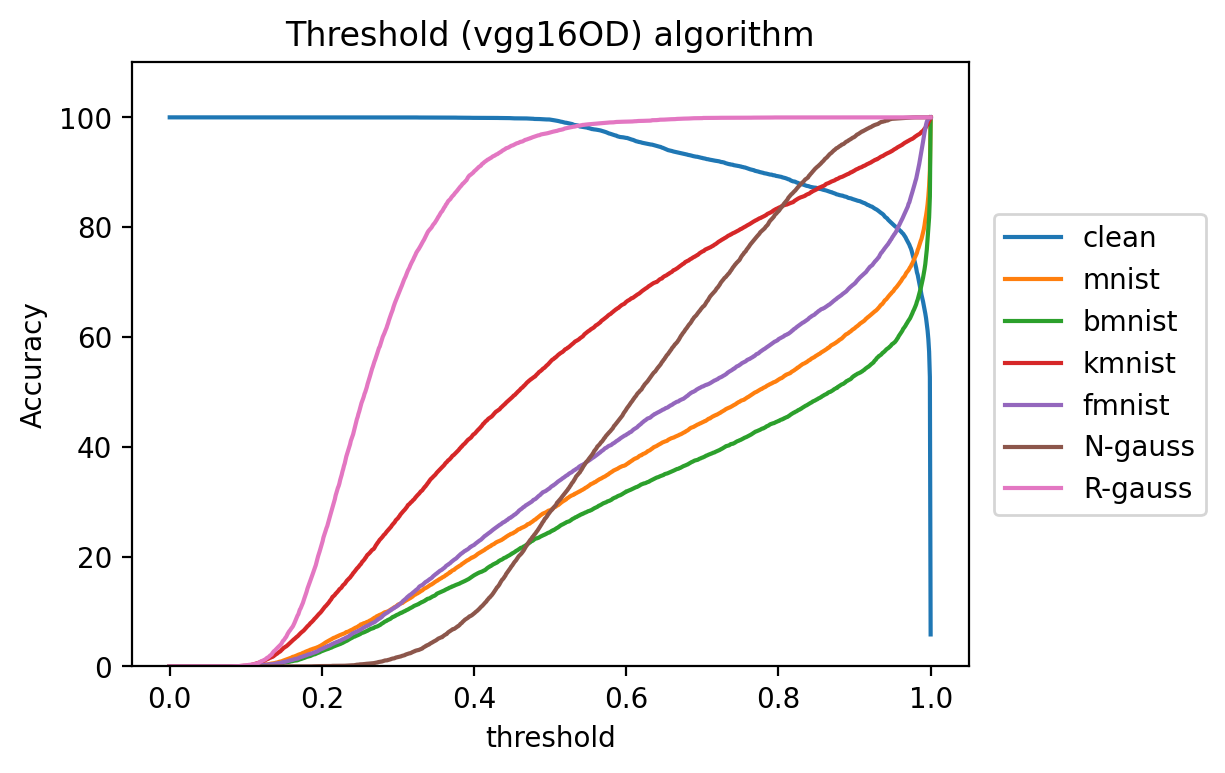

In [ ]:
accs = {"clean": clean_evals, "mnist": mnist_evals, "bmnist": bmnist_evals, "kmnist": kmnist_evals, "fmnist": fmnist_evals, "N-gauss": ngauss_evals, "R-gauss": rgauss_evals}
thrs_dict = {"Threshold": thrs}

fig, ax = plt.subplots()
plt.ylim(0, 110)
fig.set_dpi(200)
plt.title('Threshold (vgg16OD) algorithm')

for label, value in accs.items():
  plt.plot(thrs, list(value.values()), label=label)

plt.xlabel("threshold")
plt.ylabel("Accuracy")

pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))

plt.show()

# Write results to excel

In [ ]:
# !pip install xlsxwriter

In [ ]:
# import xlsxwriter

# file_name = f'/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/DPM/dpm.xlsx'
# workbook = xlsxwriter.Workbook(file_name)
# worksheet = workbook.add_worksheet()

# row = 0
# for key in thrs_dict.keys():
#     worksheet.write(row, 0, key)
#     worksheet.write_row(row, 1, thrs_dict[key])
#     row += 1

# for key in accs.keys():
#     worksheet.write(row, 0, key)
#     worksheet.write_row(row, 1, accs[key])
#     row += 1

# workbook.close()